# NI DAQ for SCF measurement

In [1]:
import LDAQ #custom version of LDAQ --> should be installed properly via pip
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt

In [2]:
# Simulation was used before first test structure was created

#def simulate_signal(t, f1, f2):
#    """
#    first argument must be time.
#    If multi_processing is True, then the function must be pickable and
#    all libraries must be imported inside the function.
#    """
#    #import numpy as np
#    sig1 = np.sin(2*np.pi*f1*t) + np.random.rand(len(t))*0.3
#    sig2 = np.cos(2*np.pi*f2*t) + np.random.rand(len(t))*0.3
#    return np.array([sig1, sig2]).T
#
#fs = 1_000_000
#acq_simulated = LDAQ.simulator.SimulatedAcquisition(acquisition_name='sim')
#acq_simulated.set_simulated_data(simulate_signal, channel_names=["ch1", "ch2"], sample_rate=fs, args=(84, 120)) # use function
#acq_simulated.run_acquisition(1.0)

## Set up NI Task with proper device

NI DAQmx is not that great at reporting errors, as it most often just prints an error codes.
The following link provides a table with a significant portion of them: [NI DAQmx Error Codes](https://www.ni.com/docs/de-DE/bundle/ni-daqmx-.net-framework-4.5.1-class-library-getting-started/page/netdaqmxerrorcodes.html?srsltid=AfmBOorhJXnpL0L-iZN-NrHwVux-ycAtkvdSPi9XsSREz3_EgUCeEQ5V)

In [2]:
input_task_name = "ni_input_task"
acquisition_name = input_task_name + "_acq"
fs = 1_000_000
#fs = 500_000

ni_task = LDAQ.national_instruments.NITask(input_task_name, sample_rate=fs)
ni_task

Task name: ni_input_task
Connected devices:
	(0) - cDAQ1
	(1) - cDAQ1Mod3
	(2) - cDAQ1Mod4
	(3) - SimDev1
Channels: []

In [3]:
device_names = ["cDAQ1Mod3", "cDAQ1Mod4"]
device_ids = [ni_task.device_list.index(device_name) for device_name in device_names]

In [4]:
num_channels_available = 0
for id in device_ids:
    num_channels_available += len(ni_task.system.devices[id].ai_physical_chans)
num_channels_per_device = num_channels_available / len(device_ids)

num_channels = 6

# check if there are enough devices for the amount of channels
assert num_channels <= num_channels_available, f"Not enough channels available on the selected devices. Desired: {num_channels}, Available: {num_channels_available}"

for i in range(0, num_channels):
    current_device_id = device_ids[int(np.floor(i / num_channels_per_device))]
    channel_ind = int(i % num_channels_per_device)

    ni_task.add_channel(channel_name=f"ch{i+1}", device_ind=current_device_id, channel_ind=channel_ind, scale=1.0, units="V", min_val=-10.0, max_val=10.0)

ni_task

Task name: ni_input_task
Connected devices:
	(0) - cDAQ1
	(1) - cDAQ1Mod3
	(2) - cDAQ1Mod4
	(3) - SimDev1
Channels: ['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6']

In [5]:
acq_ni = LDAQ.national_instruments.NIAcquisition(task_name=ni_task, acquisition_name=acquisition_name)
acq_ni

Acquisition name:     ni_input_task_acq
Number of channels:   0
Data channels:        []
Video channels:       []
Sample rate:          1000000 Hz
Continuous mode:      False
Standalone:           True

## Set up visualization from LDAQ
Sometimes has to be run a second time after running ldaq to be set up properly. At the moment not yet sure why

In [9]:
vis = LDAQ.Visualization(refresh_rate=50)

for i in range(0, num_channels):
    vis.add_lines((i,0), source=acquisition_name, channels=i, t_span=1.0)
    #vis.config_subplot((i, 0))

#vis.config_axis_link((1, 0), (0, 0), kind="x")
#vis.config_axis_link((2, 0), (0, 0), kind="y")
#vis.config_axis_link((3, 0), (0, 0), kind="xy")

## Creat Core object with acquisition & visualization

In [10]:
ldaq = LDAQ.Core(acquisitions=acq_ni, visualization=vis)
#ldaq = LDAQ.Core(acquisitions=[acq_ni])

# Set the trigger on the input task
#ldaq.set_trigger(source=acquisition_name, channel=0, level=0.025, duration=1.0, presamples=0)

ldaq

Acquisition sources (index, name):
	0 - ni_input_task_acq

Generation sources (index, name):
	None

Additional check events:
	None

Trigger settings:
	- duration [sec]      None
	- source              None
	- channel             None
	- level               None
	- presamples          None
	- type                None

In [11]:
ldaq.run(1.0, autoclose=False)
#ldaq.run()

closing app
closing app


## Extract data from measurement dict

In [12]:
measurement = ldaq.get_measurement_dict()
data = measurement[acquisition_name]
data

{'time': array([0.00000e+00, 1.00000e-06, 2.00000e-06, ..., 9.99997e-01,
        9.99998e-01, 9.99999e-01], shape=(1000000,)),
 'channel_names': ['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6'],
 'data': array([[ 8.733100e-04,  2.735255e-03,  1.415146e-03,  3.726515e-03,
          6.464081e-03,  3.350349e-03],
        [-4.981800e-04,  4.118540e-03,  2.665200e-05,  5.099280e-03,
         -3.234720e-03,  5.701870e-04],
        [-4.981800e-04, -3.131500e-05,  1.415146e-03,  3.726515e-03,
         -1.849177e-03,  1.960268e-03],
        ...,
        [ 6.359270e-03,  1.351970e-03,  4.192134e-03,  5.099280e-03,
         -3.234720e-03,  3.350349e-03],
        [ 3.616290e-03,  1.351970e-03,  2.665200e-05,  5.099280e-03,
          9.219090e-04,  1.960268e-03],
        [ 4.987780e-03,  1.351970e-03, -2.750336e-03,  3.726515e-03,
          9.219090e-04,  1.960268e-03]], shape=(1000000, 6)),
 'sample_rate': 1000000}

In [13]:
time = data["time"]
fs = data["sample_rate"]
raw_data = data["data"]


ch1_data = raw_data[:, data["channel_names"].index("ch1")]
ch2_data = raw_data[:, data["channel_names"].index("ch2")]
ch3_data = raw_data[:, data["channel_names"].index("ch3")]
ch4_data = raw_data[:, data["channel_names"].index("ch4")]
ch5_data = raw_data[:, data["channel_names"].index("ch5")]
ch6_data = raw_data[:, data["channel_names"].index("ch6")]

In [14]:
ldaq.save_measurement("noise", root="data", timestamp=True, comment="Test Comment")

'data\\20250331_145954_noise.pkl'

In [15]:
loaded_data = LDAQ.utils.load_measurement("20250331_145954_noise.pkl", directory="data")
loaded_data

{'ni_input_task_acq': {'time': array([0.00000e+00, 2.00000e-06, 4.00000e-06, ..., 9.99994e-01,
         9.99996e-01, 9.99998e-01], shape=(500000,)),
  'channel_names': ['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6'],
  'data': array([[-0.00049818,  0.00273526,  0.00141515,  0.00509928,  0.00369299,
          -0.00081989],
         [ 0.00087331,  0.00411854,  0.00141515,  0.00235375,  0.00230745,
           0.00335035],
         [-0.00461265,  0.00411854,  0.00280364,  0.00235375,  0.00092191,
           0.00196027],
         ...,
         [ 0.00635927,  0.00688511,  0.00280364,  0.00235375, -0.00323472,
           0.00196027],
         [-0.00186967,  0.0082684 ,  0.00558063,  0.00098098,  0.00092191,
           0.00196027],
         [ 0.0022448 ,  0.00273526,  0.00280364,  0.00372651, -0.00184918,
          -0.00081989]], shape=(500000, 6)),
  'sample_rate': 500000},
 'comment': 'Test Comment'}

In [16]:
from sdypy_sep005.sep005 import assert_sep005
from data_converter import measurement_dict_to_sep005

data_sep005 = measurement_dict_to_sep005(measurement)
assert_sep005(data_sep005)

t:\Research_Exchange_Matthias\02_Project\03_code\scf_daq\.venv\Lib\site-packages\ipympl\backend_nbagg.py:335: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.figure.savefig(buf, format='png', dpi='figure')


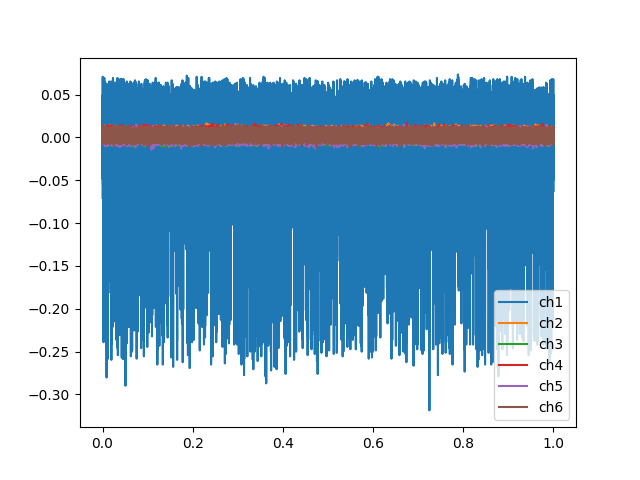

In [14]:
%matplotlib widget
plt.clf()
plt.plot(time, ch1_data, time, ch2_data, time, ch3_data, time, ch4_data, time, ch5_data, time, ch6_data)
plt.legend(["ch1", "ch2", "ch3", "ch4", "ch5", "ch6"])
plt.show()

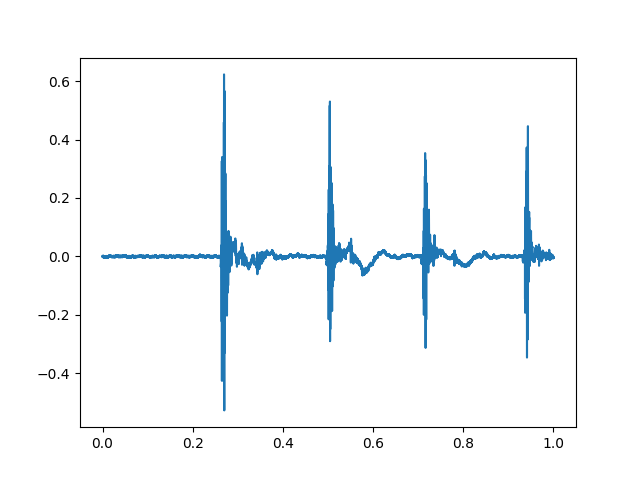

In [32]:
from scipy.signal import butter, lfilter, freqz

def butterworth_lp_filt(data, cutoff, fs, order=5):
    b, a = butter(order, cutoff, fs=fs, btype="lowpass", analog=False)
    y = lfilter(b, a, data)
    return y

f_cutoff = 25_000
ch1_data_filt = butterworth_lp_filt(ch1_data, f_cutoff, fs)

plt.clf()
plt.plot(time, ch1_data_filt)
plt.show()